# Quantum computing method for join order optimization

Valter Uotila, doctoral researcher, Unified Database Management Systems group, University of Helsinki

In [1]:
import networkx as nx
import numpy as np
import itertools
import matplotlib.pyplot as plt
import copy
from frozendict import frozendict

import dimod
from dimod.generators.constraints import combinations
from dwave.system import LeapHybridSampler
from hybrid.reference import KerberosSampler
from dwave.system.composites import EmbeddingComposite

## Query graph generator

This code generates query graphs in similar manner as described in the paper _[Adaptive Optimization of Very Large Join Queries](https://dl.acm.org/doi/pdf/10.1145/3183713.3183733)_ and in _[Heuristic and Randomized Optimization for the Join Ordering Problem](https://link.springer.com/content/pdf/10.1007/s007780050040.pdf)_. The generated query graphs are stored as json files. Relations in the database are simply modelled as positive integers which is the default for networkx. Besides the graph, we create cardinality distribution over the relations in the query. This distribution is given as a list of positive integers where the cardinality stored in the list index $i$, corresponds to the table $i$ in the graph.

TODO benchmarks: TPC-H, TPC-DS, LDBC, JOB, SQLite

### Synthetic workloads

We generate larger synthetic workloads. This generation process follows the idea from the paper _[Adaptive Optimization of Very Large Join Queries](https://dl.acm.org/doi/pdf/10.1145/3183713.3183733)_. Besides, chain, star, cycle and grid query graphs, we generate complete graphs which demonstrate the hardest case to optimize. Complete query graphs have not been considered in research as far as we know. 

In [2]:
def generate_query_graph(start, stop, step, rel_size_scale, graph_type):
    for n in range(start, stop, step):
        query_graph = None
        if graph_type == "cycle":
            query_graph = nx.cycle_graph(n)
        elif graph_type == "chain":
            query_graph = nx.path_graph(n)
        elif graph_type == "grid":
            query_graph = nx.grid_graph(n, periodic=True)
        elif graph_type == "complete":
            query_graph = nx.complete_graph(n)
        elif graph_type == "star":
            query_graph = nx.star_graph(n)
            
        rel_dist = np.random.random_sample(size=n)
        rel_dist = [int(np.ceil(value*rel_size_scale)) for value in rel_dist]
        return query_graph, rel_dist

Cardinality distribution:  [432, 110, 173]


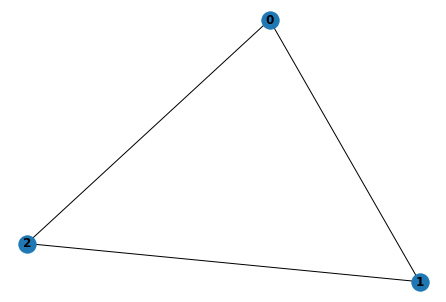

In [3]:
G, distribution = generate_query_graph(3, 4, 1, 1000, "complete")
print("Cardinality distribution: ", distribution)
nx.draw(G, with_labels=True, font_weight='bold')

## Cost function

In [4]:
def cost(left, right, cardinality_distribution):
    return 100

## Objective function

### Transformin query graph into join order graph

Join order graph is the initial QUBO which encodes query graph and costs. Every set of nodes of every connected subgraph of the query graph corresonds to a variable in the binary quadratic model. Finally, the variables of QUBO problem are the ordered tuples. Cost of joining relations becomes a weight in an edge. In QUBO problem this edge weight corresponds a quadratic bias. At this phase, the linear bias is set to 0.

In [5]:
def calculate_joins(var, join_order_graph):
    joins = []
    res_set = set(var)
    for node in join_order_graph.nodes:
        left = set(node)
        if left.issubset(res_set):
            right = tuple(res_set.difference(left))
            if right in join_order_graph:
                join = (tuple(left), right)
                join_inv = (right, tuple(left))
                if join not in joins and join_inv not in joins:
                    joins.append(join)
    return joins

def create_join_order_graph(query_graph, cardinality_distribution):
    join_order_graph = nx.Graph()
    join_order_graph_levels = {'1': []}
    
    for node in query_graph.nodes:
        join_order_graph.add_node((node,), linear_bias = 0)
        join_order_graph_levels['1'].append((node,))

    for nb_nodes in range(2, query_graph.number_of_nodes()):
        for SG in (query_graph.subgraph(selected_nodes) for selected_nodes in itertools.combinations(query_graph, nb_nodes)):
            #if nx.is_connected(SG):
                #print(SG.nodes)
            var =  tuple(SG.nodes)
            if str(len(var)) not in join_order_graph_levels:
                join_order_graph_levels[str(len(var))] = [var]
            else:
                join_order_graph_levels[str(len(var))].append(var)

            join_order_graph.add_node(var, linear_bias = 0)

            joins = calculate_joins(var, join_order_graph)
            for join in joins:
                left, right = join[0], join[1]
                cost_value = cost(left, right, cardinality_distribution)
                join_order_graph.add_edge(left, var, quadratic_bias = cost_value)
                join_order_graph.add_edge(right, var, quadratic_bias = cost_value)
    
    final_res = tuple(query_graph.nodes)
    join_order_graph_levels[str(len(final_res))] = [final_res]
    join_order_graph.add_node(final_res, linear_bias = 0)
    joins = calculate_joins(final_res, join_order_graph)
    for join in joins:
        left, right = join[0], join[1]
        cost_value = cost(left, right, cardinality_distribution)
        join_order_graph.add_edge(left, final_res, quadratic_bias = cost_value)
        join_order_graph.add_edge(right, final_res, quadratic_bias = cost_value)
    
    
    return join_order_graph, join_order_graph_levels

### Constraint 1: Single tables and the final result are always included in the join order plan

In [6]:
def constraint1(bqm, query_graph):
    for node in query_graph.nodes:
        bqm.fix_variable((node,), 1)
    bqm.fix_variable(tuple(query_graph.nodes), 1)
    return bqm

### Constraint 2: Create QUBOs for join order plan tree classes

This constraint produces QUBO problem for each join order tree class.

In [7]:
def calculate_join_order_tree_levels(relations):
    results = []
    new_rels = []
    if len(relations) < 2:
        return relations
    for i in range(0, len(relations), 2):
        if i + 1 >= len(relations):
            return results
        new_rel = (relations[i], relations[i + 1])
        new_rels.append(new_rel)
        results += calculate_join_order_tree_levels(new_rels + relations[i + 2:])
    return results

In [8]:
join_order_trees = calculate_join_order_tree_levels(list(range(20)))

In [9]:
def merge(dict1, dict2):
    for key in dict1:
        if key in dict2:
            dict2[key] += dict1[key]
        else:
            dict2[key] = dict1[key]
    return dict2

def count(lst):
    n = 0
    for i in lst:
        if type(i) is tuple:
            n += count(i)
        else:
            n += 1
    return n

def count_levels(join_order_tree):
    result = {}
    count_value = count(join_order_tree)
    result[count_value] = 1
    left, right = join_order_tree[0], join_order_tree[1]
    if type(left) == tuple:
        result1 = count_levels(left)
        result = merge(result, result1)
    if type(right) == tuple:
        result2 = count_levels(right)
        result = merge(result, result2)
    return result

In [10]:
#for tree in join_order_trees:
#    print(tree)
#    print(count_levels(tree))
#    print()

In [11]:
def constraint2(bqm, query_graph, join_order_tree_levels, tree_class):
    for level in join_order_tree_levels:
        if not level == '1' and not int(level) == len(query_graph.nodes):
            bqm_c2 = None
            if level in tree_class:
                bqm_c2 = dimod.generators.combinations(join_order_tree_levels[level], tree_class[level])
            else:
                bqm_c2 = dimod.generators.combinations(join_order_tree_levels[level], 0)
            bqm.update(bqm_c2)
    return bqm

## Complete algorithm

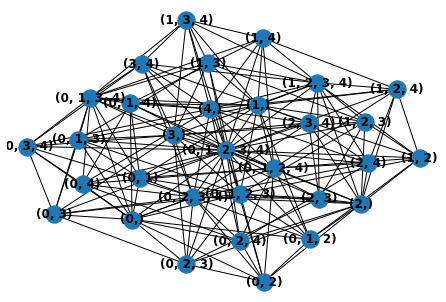

In [12]:
start, stop, step, rel_size_scale, graph_type = 5, 6, 1, 1000, "complete"
query_graph, cardinality_distribution = generate_query_graph(start, stop, step, rel_size_scale, graph_type)
join_order_graph, join_order_tree_levels = create_join_order_graph(query_graph, cardinality_distribution)
nx.draw(join_order_graph, with_labels=True, font_weight='bold')
bqm = dimod.from_networkx_graph(join_order_graph, vartype='BINARY', node_attribute_name = 'linear_bias', edge_attribute_name='quadratic_bias')

In [13]:
bqms = []
bqm = constraint1(bqm, query_graph)
join_order_trees = calculate_join_order_tree_levels(list(range(start)))
tree_classes = set()
for tree in join_order_trees:
    tree_classes.add(frozendict(count_levels(tree)))
for tree_class in tree_classes:
    new_bqm = copy.deepcopy(bqm)
    new_bqm = constraint2(new_bqm, query_graph, join_order_tree_levels, tree_class)
    bqms.append(new_bqm)
print(len(bqms))
for bqm in bqms:
    print(bqm)

3
BinaryQuadraticModel({(0, 1): 301.0, (0, 2): 301.0, (0, 3): 301.0, (0, 4): 301.0, (0, 1, 2): 401.0, (0, 1, 3): 401.0, (0, 1, 4): 401.0, (0, 2, 3): 401.0, (0, 2, 4): 401.0, (0, 3, 4): 401.0, (0, 1, 2, 3): 501.0, (0, 1, 2, 4): 501.0, (0, 1, 3, 4): 501.0, (0, 2, 3, 4): 501.0, (1, 2): 301.0, (1, 3): 301.0, (1, 4): 301.0, (1, 2, 3): 401.0, (1, 2, 4): 401.0, (1, 3, 4): 401.0, (1, 2, 3, 4): 501.0, (2, 3): 301.0, (2, 4): 301.0, (2, 3, 4): 401.0, (3, 4): 301.0}, {((0, 1), (0, 1, 2)): 100, ((0, 1), (0, 1, 3)): 100, ((0, 1), (0, 1, 4)): 100, ((0, 1), (0, 1, 2, 3)): 100, ((0, 1), (0, 1, 2, 4)): 100, ((0, 1), (0, 1, 3, 4)): 100, ((0, 1), (0, 2)): 2.0, ((0, 1), (0, 3)): 2.0, ((0, 1), (0, 4)): 2.0, ((0, 1), (1, 2)): 2.0, ((0, 1), (1, 3)): 2.0, ((0, 1), (1, 4)): 2.0, ((0, 1), (2, 3)): 2.0, ((0, 1), (2, 4)): 2.0, ((0, 1), (3, 4)): 2.0, ((0, 2), (0, 1, 2)): 100, ((0, 2), (0, 2, 3)): 100, ((0, 2), (0, 2, 4)): 100, ((0, 2), (0, 1, 2, 3)): 100, ((0, 2), (0, 1, 2, 4)): 100, ((0, 2), (0, 2, 3, 4)): 100, ((

### Divide and conquer large join order problems